In [1]:
import numpy as np
import pandas as pd
import torch 
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
import torch.nn as nn
import json
from PIL import Image as Im
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!cp "/content/drive/My Drive/Agriculture_sat_view.zip" "Ag.zip"
!unzip "Ag.zip"

In [4]:
!cp  "/content/drive/My Drive/val_81.9.pth" "val_81.9.pth"
!cp  "/content/drive/My Drive/val_list.npy"  "val_list.npy"  
##Instead Of Using Continuos Value Range For Validation ex [1400:] I created the validation set using and saved the list so to use same list(i.e same validation for all Training) using np.random.permutation(1593)[:180]

## Creating Own Image Augmentation For More Than 3 Channels 

In [5]:
def applytransform(x,y,mode):
  return x,y
  if mode=="val" :
    
    return x,y
     
  
  if random.random()<=0.5:
    return x,y
  else:
    r=random.random()
    if r<=0.5:
      
      for i in range(len(x)):x[i]=np.fliplr(x[i])
      y=np.fliplr(y)
    if r>=0.5:
      for i in range(len(x)):x[i]=np.flipud(x[i])
      y=np.flipud(y)
    if random.random()>=0.5:
      k=random.randint(0,3)
      for i in range(len(x)):x[i]=np.rot90(x[i],k)
      y=np.rot90(y,k)
    return x,y

In [6]:
def combine_image(mask_path,file_name,mode,resize=None):
  mask_file_path=mask_path+"/"+file_name
  
  mask=Im.open(mask_file_path)
  file_path=mask_path.replace("target","input")
  file_name=file_name.replace("cdl","lc8")
  file_name=file_name.split(".")[0]
  file_path=file_path+"/"+file_name
  a=Im.open(file_path+"_1.tif")
  a=np.array(a)/255
  a=torch.from_numpy(a[None])
  for i in range(1,7):
    im=Im.open(file_path+"_"+str(i+1)+".tif")
    b=np.array(im)/255
    b=torch.from_numpy(b[None])
    a=torch.cat((a,b),dim=0)
  a=a.type('torch.FloatTensor')
    
  return applytransform(a,torch.from_numpy(np.array(mask))) 
  

In [7]:
class AGNet(Dataset):
    def __init__(self,root,mask_list,transforms=None):
        self.root=root
        self.mask_list=mask_list
        self.transformation=transforms
    def __len__(self):
        return len(self.mask_list)
    def __getitem__(self,i):
      
      #print(self.mask_list[i])
      x,y=combine_image(self.root+"/target",self.mask_list[i],"val")
      return x,y
        

In [8]:
path='Agriculture_sat_view'
full_data=AGNet(path,os.listdir(path+"/target")[0:1593])

In [10]:
def Conv(ni,nf,kernel_size=3,stride=1):
  return (nn.Sequential(*[nn.Conv2d(ni,nf,stride=stride,kernel_size=kernel_size,padding=kernel_size//2),nn.BatchNorm2d(nf),nn.ReLU()]))



class Scse(nn.Module):
  def __init__(self,ni):
    super().__init__()
    self.cSE = nn.Sequential(nn.AdaptiveAvgPool2d(1),
                             nn.Conv2d(ni,ni//2,1),
                             nn.ReLU(inplace=True),
                             nn.Conv2d(ni//2, ni,1),
                             nn.Sigmoid()
                               )
    self.sSE = nn.Sequential(nn.Conv2d(ni,ni,1),
                             nn.Sigmoid())
  def forward(self,x):
    
    x=torch.addcmul(x * self.cSE(x), 1, x, self.sSE(x))
    return x


class DownBlock(nn.Module):
  def __init__(self,ni,nf,scale_factor=2,down=None):
    super().__init__()
    self.conv1=Conv(ni,nf,stride=2)
    self.conv2=Conv(nf,nf)
    if down is not None:
      
      self.scse_encoder=Scse(nf)
    else:self.scse_encoder=None
  def forward(self,x):
    inp=x
    x=self.conv2(self.conv1(x))
    x+=self.conv1(inp)
    if self.scse_encoder is None:return x
    return self.scse_encoder(x)



class UpBlock(nn.Module):
  def __init__(self,ni,nf,down=None):
    super().__init__()
    self.deconv1=nn.ConvTranspose2d(ni,nf,2,stride=2)
    self.conv=Conv(2*nf,nf)
    if down is not None:
      self.scse_decoder=Scse(nf)
    else:self.scse_decoder=None
  def forward(self,down,cross):
    x=self.deconv1(down)
    x=torch.cat((x,cross),dim=1)
    x=self.conv(x)
    if self.scse_decoder is None:return x
    return self.scse_decoder(x)



class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.d1=nn.Conv2d(7,28,kernel_size=5,padding=2,stride=1)
    self.d2=nn.Conv2d(28,98,kernel_size=3,padding=1,stride=1)
    self.down1=DownBlock(7,128,down=12)##64*64*128
    self.down2=DownBlock(128,256)##32*32*256
    self.down3=DownBlock(256,512)##16*16*512
    self.down4=DownBlock(512,1024)##8*8*1024
    self.up1=UpBlock(1024,512)#16*16*512
    self.up2=UpBlock(512,256,down=12)#32
    self.up3=UpBlock(256,128)#64
    self.fin=nn.ConvTranspose2d(128,256,2,stride=2)
  def forward(self,down):
    d1=self.down1(down)
    d2=self.down2(d1)
    d3=self.down3(d2)
    d4=self.down4(d3)
    d4=self.up1(d4,d3)
    d5=self.up2(d4,d2)
    d5=self.up3(d5,d1)
    return self.fin(d5)
    
    
    
    

In [11]:
m=Net().cuda()

In [12]:
m.load_state_dict(torch.load("val_81.9.pth"))

In [13]:
colormap = [["#000000","0","0"],
 ["#ffd300","1","1"],
 ["#ff2626","2","2"],
 ["#00a8e2","3","3"],
 ["#ff9e0a","4","4"],
 ["#267000","5","5"],
 ["#ffff00","6","6"],
 ["#000000","7","7"],
 ["#000000","8","8"],
 ["#000000","9","9"],
 ["#70a500","10","10"],
 ["#00af49","11","11"],
 ["#dda50a","12","12"],
 ["#dda50a","13","13"],
 ["#7cd3ff","14","14"],
 ["#000000","15","15"],
 ["#000000","16","16"],
 ["#000000","17","17"],
 ["#000000","18","18"],
 ["#000000","19","19"],
 ["#000000","20","20"],
 ["#e2007c","21","21"],
 ["#896054","22","22"],
 ["#d8b56b","23","23"],
 ["#a57000","24","24"],
 ["#d69ebc","25","25"],
 ["#707000","26","26"],
 ["#aa007c","27","27"],
 ["#a05989","28","28"],
 ["#700049","29","29"],
 ["#d69ebc","30","30"],
 ["#d1ff00","31","31"],
 ["#7c99ff","32","32"],
 ["#d6d600","33","33"],
 ["#d1ff00","34","34"],
 ["#00af49","35","35"],
 ["#ffa5e2","36","36"],
 ["#a5f28c","37","37"],
 ["#00af49","38","38"],
 ["#d69ebc","39","39"],
 ["#000000","40","40"],
 ["#a800e2","41","41"],
 ["#a50000","42","42"],
 ["#702600","43","43"],
 ["#00af49","44","44"],
 ["#af7cff","45","45"],
 ["#702600","46","46"],
 ["#ff6666","47","47"],
 ["#ff6666","48","48"],
 ["#ffcc66","49","49"],
 ["#ff6666","50","50"],
 ["#00af49","51","51"],
 ["#00ddaf","52","52"],
 ["#54ff00","53","53"],
 ["#f2a377","54","54"],
 ["#ff6666","55","55"],
 ["#00af49","56","56"],
 ["#7cd3ff","57","57"],
 ["#e8bfff","58","58"],
 ["#afffdd","59","59"],
 ["#00af49","60","60"],
 ["#bfbf77","61","61"],
 ["#000000","62","62"],
 ["#93cc93","63","63"],
 ["#c6d69e","64","64"],
 ["#ccbfa3","65","65"],
 ["#ff00ff","66","66"],
 ["#ff8eaa","67","67"],
 ["#ba004f","68","68"],
 ["#704489","69","69"],
 ["#007777","70","70"],
 ["#af9970","71","71"],
 ["#ffff7c","72","72"],
 ["#000000","73","73"],
 ["#b5705b","74","74"],
 ["#00a582","75","75"],
 ["#e8d6af","76","76"],
 ["#af9970","77","77"],
 ["#000000","78","78"],
 ["#000000","79","79"],
 ["#000000","80","80"],
 ["#f2f2f2","81","81"],
 ["#999999","82","82"],
 ["#4970a3","83","83"],
 ["#000000","84","84"],
 ["#000000","85","85"],
 ["#000000","86","86"],
 ["#7cafaf","87","87"],
 ["#e8ffbf","88","88"],
 ["#000000","89","89"],
 ["#000000","90","90"],
 ["#000000","91","91"],
 ["#00ffff","92","92"],
 ["#000000","93","93"],
 ["#000000","94","94"],
 ["#000000","95","95"],
 ["#000000","96","96"],
 ["#000000","97","97"],
 ["#000000","98","98"],
 ["#000000","99","99"],
 ["#000000","100","100"],
 ["#000000","101","101"],
 ["#000000","102","102"],
 ["#000000","103","103"],
 ["#000000","104","104"],
 ["#000000","105","105"],
 ["#000000","106","106"],
 ["#000000","107","107"],
 ["#000000","108","108"],
 ["#000000","109","109"],
 ["#000000","110","110"],
 ["#4970a3","111","111"],
 ["#d3e2f9","112","112"],
 ["#000000","113","113"],
 ["#000000","114","114"],
 ["#000000","115","115"],
 ["#000000","116","116"],
 ["#000000","117","117"],
 ["#000000","118","118"],
 ["#000000","119","119"],
 ["#000000","120","120"],
 ["#999999","121","121"],
 ["#999999","122","122"],
 ["#999999","123","123"],
 ["#999999","124","124"],
 ["#000000","125","125"],
 ["#000000","126","126"],
 ["#000000","127","127"],
 ["#000000","128","128"],
 ["#000000","129","129"],
 ["#000000","130","130"],
 ["#ccbfa3","131","131"],
 ["#000000","132","132"],
 ["#000000","133","133"],
 ["#000000","134","134"],
 ["#000000","135","135"],
 ["#000000","136","136"],
 ["#000000","137","137"],
 ["#000000","138","138"],
 ["#000000","139","139"],
 ["#000000","140","140"],
 ["#93cc93","141","141"],
 ["#93cc93","142","142"],
 ["#93cc93","143","143"],
 ["#000000","144","144"],
 ["#000000","145","145"],
 ["#000000","146","146"],
 ["#000000","147","147"],
 ["#000000","148","148"],
 ["#000000","149","149"],
 ["#000000","150","150"],
 ["#000000","151","151"],
 ["#c6d69e","152","152"],
 ["#000000","153","153"],
 ["#000000","154","154"],
 ["#000000","155","155"],
 ["#000000","156","156"],
 ["#000000","157","157"],
 ["#000000","158","158"],
 ["#000000","159","159"],
 ["#000000","160","160"],
 ["#000000","161","161"],
 ["#000000","162","162"],
 ["#000000","163","163"],
 ["#000000","164","164"],
 ["#000000","165","165"],
 ["#000000","166","166"],
 ["#000000","167","167"],
 ["#000000","168","168"],
 ["#000000","169","169"],
 ["#000000","170","170"],
 ["#000000","171","171"],
 ["#000000","172","172"],
 ["#000000","173","173"],
 ["#000000","174","174"],
 ["#000000","175","175"],
 ["#e8ffbf","176","176"],
 ["#000000","177","177"],
 ["#000000","178","178"],
 ["#000000","179","179"],
 ["#000000","180","180"],
 ["#000000","181","181"],
 ["#000000","182","182"],
 ["#000000","183","183"],
 ["#000000","184","184"],
 ["#000000","185","185"],
 ["#000000","186","186"],
 ["#000000","187","187"],
 ["#000000","188","188"],
 ["#000000","189","189"],
 ["#7cafaf","190","190"],
 ["#000000","191","191"],
 ["#000000","192","192"],
 ["#000000","193","193"],
 ["#000000","194","194"],
 ["#7cafaf","195","195"],
 ["#000000","196","196"],
 ["#000000","197","197"],
 ["#000000","198","198"],
 ["#000000","199","199"],
 ["#000000","200","200"],
 ["#000000","201","201"],
 ["#000000","202","202"],
 ["#000000","203","203"],
 ["#00ff8c","204","204"],
 ["#d69ebc","205","205"],
 ["#ff6666","206","206"],
 ["#ff6666","207","207"],
 ["#ff6666","208","208"],
 ["#ff6666","209","209"],
 ["#ff8eaa","210","210"],
 ["#334933","211","211"],
 ["#e27026","212","212"],
 ["#ff6666","213","213"],
 ["#ff6666","214","214"],
 ["#000000","215","215"],
 ["#ff6666","216","216"],
 ["#af9970","217","217"],
 ["#ff8eaa","218","218"],
 ["#ff6666","219","219"],
 ["#ff8eaa","220","220"],
 ["#ff6666","221","221"],
 ["#ff6666","222","222"],
 ["#ff8eaa","223","223"],
 ["#00af49","224","224"],
 ["#ffd300","225","225"],
 ["#ffd300","226","226"],
 ["#ff6666","227","227"],
 ["#000000","228","228"],
 ["#ff6666","229","229"],
 ["#896054","230","230"],
 ["#ff6666","231","231"],
 ["#ff2626","232","232"],
 ["#e2007c","233","233"],
 ["#ff9e0a","234","234"],
 ["#ff9e0a","235","235"],
 ["#a57000","236","236"],
 ["#ffd300","237","237"],
 ["#a57000","238","238"],
 ["#267000","239","239"],
 ["#267000","240","240"],
 ["#ffd300","241","241"],
 ["#000099","242","242"],
 ["#ff6666","243","243"],
 ["#ff6666","244","244"],
 ["#ff6666","245","245"],
 ["#ff6666","246","246"],
 ["#ff6666","247","247"],
 ["#ff6666","248","248"],
 ["#ff6666","249","249"],
 ["#ff6666","250","250"],
 ["#ffd300","251","251"],
 ["#267000","252","252"],
 ["#a57000","253","253"],
 ["#267000","254","254"],
 ["#707000","255","255"]]


def hex_to_rgb(value):
 value = value.lstrip('#')
 lv = len(value)
 return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def getCDLRGB(cdlvalue):
 # print("get cdl:", cdlvalue)
 for x in range(len(colormap)):
   if(int(colormap[x][1])==cdlvalue):
    hex = colormap[x][0]
    rgb = hex_to_rgb(hex)
    return rgb

print("The color of class 5 is: ", getCDLRGB(5))

The color of class 5 is:  (38, 112, 0)


In [14]:
label_colours=[np.array(getCDLRGB(i)) for i in range(0,256)]

label_colours=np.array(label_colours)
def view_annotated(tensor, plot=True):
    temp = tensor.numpy()
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0,256):
        r[temp==l]=label_colours[l,0]
        g[temp==l]=label_colours[l,1]
        b[temp==l]=label_colours[l,2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:,:,0] = (r/255.0)#[:,:,0]
    rgb[:,:,1] = (g/255.0)#[:,:,1]
    rgb[:,:,2] = (b/255.0)#[:,:,2]
    if plot:
        plt.imshow(rgb)
        plt.show()
    
    

In [15]:
list_images=np.load("val_list.npy")

In [16]:
len(list_images)

180

## Generating Segmentation Masks Using The Models

***THe Ground Truth Image is The First One While The Second One is the Generated Image***

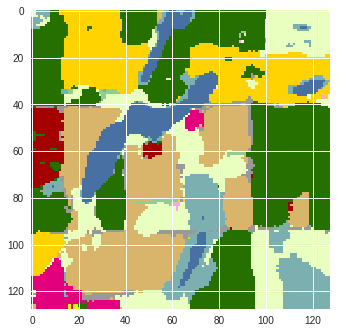

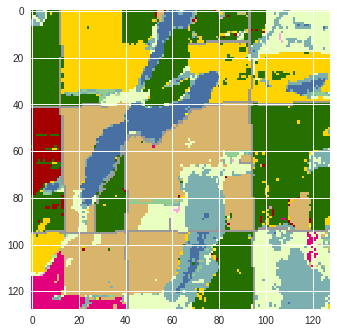

In [18]:
import matplotlib.pyplot as plt
x,y=full_data.__getitem__(list_images[0])
y_pred=m.forward(x[None].cuda())
y_pred_cat=torch.argmax(y_pred,dim=1)
predicted=view_annotated(y_pred_cat.cpu()[0])
original=view_annotated(y.cpu())

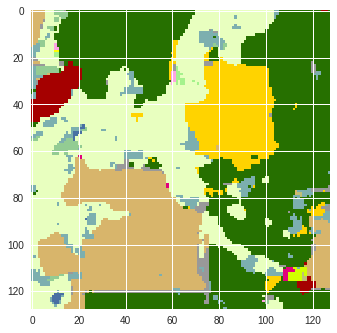

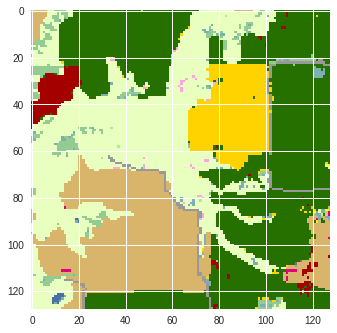

In [19]:
import matplotlib.pyplot as plt
x,y=full_data.__getitem__(list_images[1])
y_pred=m.forward(x[None].cuda())
y_pred_cat=torch.argmax(y_pred,dim=1)
predicted=view_annotated(y_pred_cat.cpu()[0])
original=view_annotated(y.cpu())

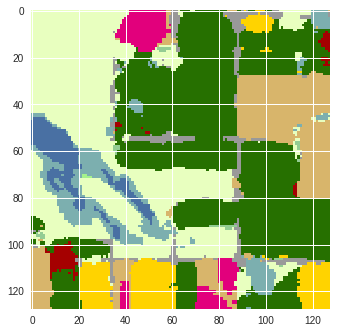

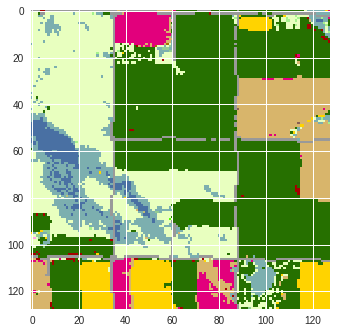

In [20]:
import matplotlib.pyplot as plt
x,y=full_data.__getitem__(list_images[2])
y_pred=m.forward(x[None].cuda())
y_pred_cat=torch.argmax(y_pred,dim=1)
predicted=view_annotated(y_pred_cat.cpu()[0])
original=view_annotated(y.cpu())